In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

import joblib


In [2]:
import pandas as pd
import numpy as np

# -----------------------------------------
# LOAD DATA
# -----------------------------------------
df = pd.read_csv("Crime Prediction in Chicago_Dataset.csv", low_memory=False)

print("Initial shape:", df.shape)
print(df.head())
print(df.info())


Initial shape: (239558, 22)
         ID Case Number             Date                   Block  IUCR  \
0  12592454    JF113025  1/14/2022 15:55       067XX S MORGAN ST  2826   
1  12785595    JF346553   8/5/2022 21:00  072XX S UNIVERSITY AVE  1544   
2  12808281    JF373517  8/14/2022 14:00     055XX W ARDMORE AVE  1562   
3  12888104    JF469015  11/10/2022 3:47          072XX S MAY ST  1477   
4  13209277    JG422539   8/15/2022 9:00    0000X W JACKSON BLVD   810   

        Primary Type                       Description  \
0      OTHER OFFENSE    HARASSMENT BY ELECTRONIC MEANS   
1        SEX OFFENSE    SEXUAL EXPLOITATION OF A CHILD   
2        SEX OFFENSE  AGGRAVATED CRIMINAL SEXUAL ABUSE   
3  WEAPONS VIOLATION        RECKLESS FIREARM DISCHARGE   
4              THEFT                         OVER $500   

           Location Description  Arrest  Domestic  ...  Ward  Community Area  \
0                     RESIDENCE   False      True  ...  16.0              68   
1                 

In [3]:
df = df.iloc[:-150000]


In [4]:
df.shape

(89558, 22)

In [5]:
df.isnull().sum()

ID                         0
Case Number                0
Date                       0
Block                      0
IUCR                       0
Primary Type               0
Description                0
Location Description     421
Arrest                     0
Domestic                   0
Beat                       0
District                   0
Ward                       6
Community Area             0
FBI Code                   0
X Coordinate            1895
Y Coordinate            1895
Year                       0
Updated On                 0
Latitude                1895
Longitude               1895
Location                1895
dtype: int64

In [6]:
df = df.drop_duplicates()
print("Duplicates removed:", df.duplicated().sum())
print(df.isnull().sum())


Duplicates removed: 0
ID                         0
Case Number                0
Date                       0
Block                      0
IUCR                       0
Primary Type               0
Description                0
Location Description     421
Arrest                     0
Domestic                   0
Beat                       0
District                   0
Ward                       6
Community Area             0
FBI Code                   0
X Coordinate            1895
Y Coordinate            1895
Year                       0
Updated On                 0
Latitude                1895
Longitude               1895
Location                1895
dtype: int64


In [7]:
# --- Handle Missing Values ---

# Identify numeric and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Fill missing numeric values with median
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill missing categorical values with "Unknown"
df[cat_cols] = df[cat_cols].fillna("Unknown")

# Specifically check and handle coordinates
df = df.dropna(subset=["Latitude", "Longitude"])  # Best practice for spatial models

# Final check
print("Remaining Null Values:\n", df.isnull().sum())
print("Final Shape:", df.shape)


Remaining Null Values:
 ID                      0
Case Number             0
Date                    0
Block                   0
IUCR                    0
Primary Type            0
Description             0
Location Description    0
Arrest                  0
Domestic                0
Beat                    0
District                0
Ward                    0
Community Area          0
FBI Code                0
X Coordinate            0
Y Coordinate            0
Year                    0
Updated On              0
Latitude                0
Longitude               0
Location                0
dtype: int64
Final Shape: (89558, 22)


In [8]:
# Remove coordinates that are impossible
df = df[(df["Latitude"] > 41.0) & (df["Latitude"] < 42.5)]
df = df[(df["Longitude"] < -87.0) & (df["Longitude"] > -88.5)]



In [9]:
df['Primary Type'] = df['Primary Type'].str.upper().str.strip()
df['Location Description'] = df['Location Description'].str.upper().str.strip()


In [10]:
df = df[df['District'].between(1, 25)]


In [11]:
df = df[df['Beat'] > 100]


In [12]:
def categorize_crime(pt):
    pt = pt.upper()   # standardize

    # Violent Crime
    if pt in ["HOMICIDE", "BATTERY", "ASSAULT", "ROBBERY", "KIDNAPPING"]:
        return "Violent Crime"

    # Property Crime
    elif pt in ["BURGLARY", "THEFT", "MOTOR VEHICLE THEFT", "ARSON"]:
        return "Property Crime"

    # Drug / Narcotics
    elif pt in ["NARCOTICS", "DRUG ABUSE"]:
        return "Drug Crime"

    # Sexual Crimes
    elif pt in ["CRIM SEXUAL ASSAULT", "PROSTITUTION"]:
        return "Sex Crime"

    # Public Disorder / Other
    else:
        return "Other Crime"


df["Crime Category"] = df["Primary Type"].apply(categorize_crime)


In [13]:
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Crime Category
0,12592454,JF113025,1/14/2022 15:55,067XX S MORGAN ST,2826,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,RESIDENCE,False,True,...,68,26,1170805.0,1860170.0,2022,9/14/2023 15:41,41.771782,-87.649437,"(41.771782439, -87.649436929)",Other Crime
1,12785595,JF346553,8/5/2022 21:00,072XX S UNIVERSITY AVE,1544,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,APARTMENT,True,False,...,69,17,1185135.0,1857211.0,2022,9/14/2023 15:41,41.763338,-87.597001,"(41.763337967, -87.597001131)",Other Crime
2,12808281,JF373517,8/14/2022 14:00,055XX W ARDMORE AVE,1562,SEX OFFENSE,AGGRAVATED CRIMINAL SEXUAL ABUSE,RESIDENCE,False,False,...,11,17,1138383.0,1937953.0,2022,9/14/2023 15:41,41.985875,-87.766404,"(41.985875279, -87.766403857)",Other Crime
3,12888104,JF469015,11/10/2022 3:47,072XX S MAY ST,1477,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,STREET,False,False,...,68,15,1169903.0,1856822.0,2022,9/14/2023 15:41,41.762615,-87.652840,"(41.76261474, -87.652840463)",Other Crime
4,13209277,JG422539,8/15/2022 9:00,0000X W JACKSON BLVD,810,THEFT,OVER $500,COMMERCIAL / BUSINESS OFFICE,False,False,...,32,6,1167418.0,1893150.0,2022,9/14/2023 15:43,41.862523,-87.660886,Unknown,Property Crime


In [14]:
# Make sure Date column is datetime type
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extract month as a new column
df['MonthofCrime'] = df['Date'].dt.month

# Extract day, year, etc. if needed
df['DayofCrime'] = df['Date'].dt.day
df['YearofCrime'] = df['Date'].dt.year

# Check
df.head()


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Crime Category,MonthofCrime,DayofCrime,YearofCrime
0,12592454,JF113025,2022-01-14 15:55:00,067XX S MORGAN ST,2826,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,RESIDENCE,False,True,...,1860170.0,2022,9/14/2023 15:41,41.771782,-87.649437,"(41.771782439, -87.649436929)",Other Crime,1,14,2022
1,12785595,JF346553,2022-08-05 21:00:00,072XX S UNIVERSITY AVE,1544,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,APARTMENT,True,False,...,1857211.0,2022,9/14/2023 15:41,41.763338,-87.597001,"(41.763337967, -87.597001131)",Other Crime,8,5,2022
2,12808281,JF373517,2022-08-14 14:00:00,055XX W ARDMORE AVE,1562,SEX OFFENSE,AGGRAVATED CRIMINAL SEXUAL ABUSE,RESIDENCE,False,False,...,1937953.0,2022,9/14/2023 15:41,41.985875,-87.766404,"(41.985875279, -87.766403857)",Other Crime,8,14,2022
3,12888104,JF469015,2022-11-10 03:47:00,072XX S MAY ST,1477,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,STREET,False,False,...,1856822.0,2022,9/14/2023 15:41,41.762615,-87.652840,"(41.76261474, -87.652840463)",Other Crime,11,10,2022
4,13209277,JG422539,2022-08-15 09:00:00,0000X W JACKSON BLVD,810,THEFT,OVER $500,COMMERCIAL / BUSINESS OFFICE,False,False,...,1893150.0,2022,9/14/2023 15:43,41.862523,-87.660886,Unknown,Property Crime,8,15,2022


In [15]:
import pandas as pd

# Make sure the 'DateofCrime' column exists and convert to datetime
df['FormattedDate'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')

# Extract the day of the week (Monday=0, Sunday=6)
df['DayOfWeek'] = df['FormattedDate'].dt.dayofweek


print(df[['Date', 'FormattedDate', 'DayOfWeek']].head())


                 Date       FormattedDate  DayOfWeek
0 2022-01-14 15:55:00 2022-01-14 15:55:00          4
1 2022-08-05 21:00:00 2022-08-05 21:00:00          4
2 2022-08-14 14:00:00 2022-08-14 14:00:00          6
3 2022-11-10 03:47:00 2022-11-10 03:47:00          3
4 2022-08-15 09:00:00 2022-08-15 09:00:00          0


In [16]:
import pandas as pd

# Make sure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extract month as integer
df['MonthofCrime'] = df['Date'].dt.month

# Optional: show first few rows
print(df[['Date', 'MonthofCrime']].head())


                 Date  MonthofCrime
0 2022-01-14 15:55:00             1
1 2022-08-05 21:00:00             8
2 2022-08-14 14:00:00             8
3 2022-11-10 03:47:00            11
4 2022-08-15 09:00:00             8


In [17]:
import pandas as pd
import numpy as np

# Make sure 'Date' column is datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# -----------------------------
# Extract time part from Date
# -----------------------------
# In Pandas, we can directly get the time
df['time_part'] = df['Date'].dt.time

# -----------------------------
# Extract Hour of the day
# -----------------------------
df['HourofDay'] = df['Date'].dt.hour

# -----------------------------
# Classify as DAY or NIGHT
# -----------------------------
# Day = 6 AM to 6 PM, Night = otherwise
df['DayorNight'] = np.where(df['HourofDay'].between(6, 18), 'DAY', 'NIGHT')

# -----------------------------
# Convert Community Area and District to string
# -----------------------------
df['Community Area'] = df['Community Area'].astype(str)
df['District'] = df['District'].astype(str)

# -----------------------------
# Optional: check result
# -----------------------------
print(df[['Date', 'time_part', 'HourofDay', 'DayorNight', 'Community Area', 'District']].head())


                 Date time_part  HourofDay DayorNight Community Area District
0 2022-01-14 15:55:00  15:55:00         15        DAY             68        7
1 2022-08-05 21:00:00  21:00:00         21      NIGHT             69        3
2 2022-08-14 14:00:00  14:00:00         14        DAY             11       16
3 2022-11-10 03:47:00  03:47:00          3      NIGHT             68        7
4 2022-08-15 09:00:00  09:00:00          9        DAY             32        1


In [18]:
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Location,Crime Category,MonthofCrime,DayofCrime,YearofCrime,FormattedDate,DayOfWeek,time_part,HourofDay,DayorNight
0,12592454,JF113025,2022-01-14 15:55:00,067XX S MORGAN ST,2826,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,RESIDENCE,False,True,...,"(41.771782439, -87.649436929)",Other Crime,1,14,2022,2022-01-14 15:55:00,4,15:55:00,15,DAY
1,12785595,JF346553,2022-08-05 21:00:00,072XX S UNIVERSITY AVE,1544,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,APARTMENT,True,False,...,"(41.763337967, -87.597001131)",Other Crime,8,5,2022,2022-08-05 21:00:00,4,21:00:00,21,NIGHT
2,12808281,JF373517,2022-08-14 14:00:00,055XX W ARDMORE AVE,1562,SEX OFFENSE,AGGRAVATED CRIMINAL SEXUAL ABUSE,RESIDENCE,False,False,...,"(41.985875279, -87.766403857)",Other Crime,8,14,2022,2022-08-14 14:00:00,6,14:00:00,14,DAY
3,12888104,JF469015,2022-11-10 03:47:00,072XX S MAY ST,1477,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,STREET,False,False,...,"(41.76261474, -87.652840463)",Other Crime,11,10,2022,2022-11-10 03:47:00,3,03:47:00,3,NIGHT
4,13209277,JG422539,2022-08-15 09:00:00,0000X W JACKSON BLVD,810,THEFT,OVER $500,COMMERCIAL / BUSINESS OFFICE,False,False,...,Unknown,Property Crime,8,15,2022,2022-08-15 09:00:00,0,09:00:00,9,DAY


In [19]:
cols_to_drop = [
    "DayofCrime",
    "YearofCrime",
    "time_part",
    "IUCR",
    "Location",
    "MonthofCrime",
    "FormattedDate",
    "Date",
    "X Coordinate",
    "Y Coordinate",
    "Block",
    "Beat"
]
df = df.drop(columns=cols_to_drop, errors='ignore')


In [20]:
df.head()

,ID,Case Number,Primary Type,Description,Location Description,Arrest,Domestic,District,Ward,Community Area,FBI Code,Year,Updated On,Latitude,Longitude,Crime Category,DayOfWeek,HourofDay,DayorNight
0,12592454,JF113025,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,RESIDENCE,False,True,7,16.0,68,26,2022,9/14/2023 15:41,41.771782,-87.649437,Other Crime,4,15,DAY
1,12785595,JF346553,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,APARTMENT,True,False,3,5.0,69,17,2022,9/14/2023 15:41,41.763338,-87.597001,Other Crime,4,21,NIGHT
2,12808281,JF373517,SEX OFFENSE,AGGRAVATED CRIMINAL SEXUAL ABUSE,RESIDENCE,False,False,16,39.0,11,17,2022,9/14/2023 15:41,41.985875,-87.766404,Other Crime,6,14,DAY
3,12888104,JF469015,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,STREET,False,False,7,17.0,68,15,2022,9/14/2023 15:41,41.762615,-87.652840,Other Crime,3,3,NIGHT
4,13209277,JG422539,THEFT,OVER $500,COMMERCIAL / BUSINESS OFFICE,False,False,1,4.0,32,6,2022,9/14/2023 15:43,41.862523,-87.660886,Property Crime,0,9,DAY


In [21]:
cols_to_drop = [
    "Ward",
    "Community Area",
    "FBI Code",
    "Year",
    "Updated On",
    "Latitude",
    "Longitude"   
]
df = df.drop(columns=cols_to_drop, errors='ignore')

In [22]:
# Save the modified dataframe to CSV
df.to_csv("crime_data_finalfortraining.csv", index=False)

In [23]:
df.head()

,ID,Case Number,Primary Type,Description,Location Description,Arrest,Domestic,District,Crime Category,DayOfWeek,HourofDay,DayorNight
0,12592454,JF113025,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,RESIDENCE,False,True,7,Other Crime,4,15,DAY
1,12785595,JF346553,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,APARTMENT,True,False,3,Other Crime,4,21,NIGHT
2,12808281,JF373517,SEX OFFENSE,AGGRAVATED CRIMINAL SEXUAL ABUSE,RESIDENCE,False,False,16,Other Crime,6,14,DAY
3,12888104,JF469015,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,STREET,False,False,7,Other Crime,3,3,NIGHT
4,13209277,JG422539,THEFT,OVER $500,COMMERCIAL / BUSINESS OFFICE,False,False,1,Property Crime,0,9,DAY


In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report


df = df[["ID","Case Number","Primary Type","Description",
         "Location Description","Domestic","District",
         "DayorNight","HourofDay","Arrest","DayOfWeek","Crime Category"]]

# -----------------------------
# Encode binary columns
# -----------------------------
df['Arrest'] = df['Arrest'].astype(int)      # True/False -> 1/0
df['Domestic'] = df['Domestic'].astype(int)  # True/False -> 1/0

# -----------------------------
# Encode target column 'Crime Category'
# -----------------------------
crime_encoder = LabelEncoder()
df['Crime Category'] = crime_encoder.fit_transform(df['Crime Category'])

# -----------------------------
# One-hot encode categorical features
# -----------------------------
categorical_columns = ['Primary Type', 'Description', 'Location Description',
                       'Domestic', 'District', 'DayorNight', 'DayOfWeek', 'HourofDay']

df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# -----------------------------
# Prepare features and targets
# -----------------------------
targets = ['Arrest', 'Crime Category']
X = df_encoded.drop(columns=targets + ['ID', 'Case Number'])
y = df_encoded[targets]

# -----------------------------
# Train/test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y['Crime Category']
)

# -----------------------------
# Train MultiOutput Random Forest
# -----------------------------
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
multi_target_rf = MultiOutputClassifier(rf)
multi_target_rf.fit(X_train, y_train)

# -----------------------------
# Make predictions
# -----------------------------
y_pred = multi_target_rf.predict(X_test)
y_pred_df = pd.DataFrame(y_pred, columns=y_test.columns)

# -----------------------------
# Evaluate predictions
# -----------------------------
print("=== Arrest Prediction ===")
print("Accuracy:", accuracy_score(y_test['Arrest'], y_pred_df['Arrest']))
print(classification_report(y_test['Arrest'], y_pred_df['Arrest'], zero_division=0))

print("\n=== Crime Category Prediction ===T")
print("Accuracy:", accuracy_score(y_test['Crime Category'], y_pred_df['Crime Category']))
print(classification_report(y_test['Crime Category'], y_pred_df['Crime Category'], zero_division=0))

# Optionally, convert Crime Category back to original labels
y_pred_df['Crime Category'] = crime_encoder.inverse_transform(y_pred_df['Crime Category'])


=== Arrest Prediction ===
Accuracy: 0.9163642454357658
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     15686
           1       0.74      0.51      0.60      2225

    accuracy                           0.92     17911
   macro avg       0.84      0.74      0.78     17911
weighted avg       0.91      0.92      0.91     17911


=== Crime Category Prediction ===
Accuracy: 0.9997766735525655
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       389
           1       1.00      1.00      1.00      6025
           2       1.00      1.00      1.00      5975
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00      5496

    accuracy                           1.00     17911
   macro avg       1.00      1.00      1.00     17911
weighted avg       1.00      1.00      1.00     17911



In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report


df = df[["ID","Case Number","Primary Type","Description",
         "Location Description","Domestic","District",
         "DayorNight","HourofDay","Arrest","DayOfWeek","Crime Category"]]

# -----------------------------
# Encode binary columns
# -----------------------------
df['Arrest'] = df['Arrest'].astype(int)      # True/False -> 1/0
df['Domestic'] = df['Domestic'].astype(int)  # True/False -> 1/0

# -----------------------------
# Encode target column 'Crime Category'
# -----------------------------
crime_encoder = LabelEncoder()
df['Crime Category'] = crime_encoder.fit_transform(df['Crime Category'])

# -----------------------------
# Prepare features (X) and targets (y)
# -----------------------------
targets = ['Arrest', 'Crime Category']
X = df.drop(columns=targets + ['ID', 'Case Number'])
y = df[targets]

# -----------------------------
# One-hot encode categorical features using ColumnTransformer
# -----------------------------
categorical_features = ['Primary Type','Description','Location Description',
                        'Domestic','District','DayorNight','DayOfWeek','HourofDay']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ],
    remainder='passthrough'  # keep other numeric columns
)

# Fit and transform features
X_encoded = preprocessor.fit_transform(X)

# -----------------------------
# Train/test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y['Crime Category']
)

# -----------------------------
# Multi-output Random Forest
# -----------------------------
rf = RandomForestClassifier(n_estimators=200, max_features='sqrt', random_state=42, class_weight='balanced')
multi_target_rf = MultiOutputClassifier(rf)
multi_target_rf.fit(X_train, y_train)

# -----------------------------
# Make predictions
# -----------------------------
y_pred = multi_target_rf.predict(X_test)
y_pred_df = pd.DataFrame(y_pred, columns=y_test.columns)

# -----------------------------
# Evaluate predictions
# -----------------------------
print("=== Arrest Prediction ===")
print("Accuracy:", accuracy_score(y_test['Arrest'], y_pred_df['Arrest']))
print(classification_report(y_test['Arrest'], y_pred_df['Arrest'], zero_division=0))

print("\n=== Crime Category Prediction ===")
print("Accuracy:", accuracy_score(y_test['Crime Category'], y_pred_df['Crime Category']))
print(classification_report(y_test['Crime Category'], y_pred_df['Crime Category'], zero_division=0))

# -----------------------------
# Optional: convert Crime Category back to original labels
# -----------------------------
y_pred_df['Crime Category'] = crime_encoder.inverse_transform(y_pred_df['Crime Category'])


=== Arrest Prediction ===
Accuracy: 0.9166434034950589
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     15686
           1       0.74      0.51      0.60      2225

    accuracy                           0.92     17911
   macro avg       0.84      0.74      0.78     17911
weighted avg       0.91      0.92      0.91     17911


=== Crime Category Prediction ===
Accuracy: 0.9997766735525655
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       389
           1       1.00      1.00      1.00      6025
           2       1.00      1.00      1.00      5975
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00      5496

    accuracy                           1.00     17911
   macro avg       1.00      1.00      1.00     17911
weighted avg       1.00      1.00      1.00     17911



In [26]:
import joblib

joblib.dump(multi_target_rf, "multi_target_rf_model.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")
joblib.dump(crime_encoder, "crime_encoder.pkl")


['crime_encoder.pkl']

In [27]:
from sklearn.preprocessing import LabelEncoder
import joblib

# Encode Crime Category
crime_encoder = LabelEncoder()
df['Crime Category'] = crime_encoder.fit_transform(df['Crime Category'])

# Save encoder for later
joblib.dump(crime_encoder, "crime_encoder.pkl")


['crime_encoder.pkl']

In [28]:
import pandas as pd
import joblib

# Load encoder
crime_encoder = joblib.load("crime_encoder.pkl")

# Example predictions from your model
y_pred_crime_numeric = [2, 1, 0]  # Make sure these are outputs from your model

# Convert to DataFrame
df_predictions = pd.DataFrame({'Predicted_Crime_Category': y_pred_crime_numeric})

# Convert numeric labels to text
df_predictions['Predicted_Crime_Category_Text'] = crime_encoder.inverse_transform(
    df_predictions['Predicted_Crime_Category']
)

print(df_predictions)


   Predicted_Crime_Category  Predicted_Crime_Category_Text
0                         2                              2
1                         1                              1
2                         0                              0


In [29]:
import joblib

crime_encoder = joblib.load("crime_encoder.pkl")
print(crime_encoder.classes_)


[0 1 2 3 4]


In [30]:
import pandas as pd

# Numeric predictions from your model
y_pred_crime_numeric = [0, 1, 2, 3, 4]  # Replace with your model output

# Numeric to Crime Category mapping
crime_mapping = {
    1: 'Other Crime',       # e.g., OTHER OFFENSE
    2: 'Property Crime',    # e.g., THEFT, BURGLARY
    3: 'Sex Crime',         # e.g., SEX OFFENSE, CRIMINAL SEXUAL ASSAULT
    4: 'Violent Crime',     # e.g., BATTERY, ROBBERY, HOMICIDE
    0: 'Drug Crime'         # e.g., NARCOTICS, DRUG ABUSE (if you had it)
}


# Convert to DataFrame
df_predictions = pd.DataFrame({'Predicted_Crime_Category': y_pred_crime_numeric})

# Map numeric to text
df_predictions['Predicted_Crime_Category_Text'] = df_predictions['Predicted_Crime_Category'].map(crime_mapping)

print(df_predictions)


   Predicted_Crime_Category Predicted_Crime_Category_Text
0                         0                    Drug Crime
1                         1                   Other Crime
2                         2                Property Crime
3                         3                     Sex Crime
4                         4                 Violent Crime


In [39]:
import pandas as pd
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


def get_user_input():
    print("Enter details of the crime:")
    
    primary_type = input("Primary Type: ")
    description = input("Description: ")
    location = input("Location Description: ")
    domestic = input("Domestic (0=No, 1=Yes): ")
    district = input("District (number): ")
    day_of_week = input("DayOfWeek (0=Sunday,...6=Saturday): ")
    hour_of_day = input("HourofDay (0-23): ")
    day_or_night = input("DayorNight (DAY/NIGHT): ")

    # Create DataFrame for a single row
    input_data = pd.DataFrame([{
        'Primary Type': primary_type,
        'Description': description,
        'Location Description': location,
        'Domestic': int(domestic),
        'District': str(district),
        'DayOfWeek': int(day_of_week),
        'HourofDay': int(hour_of_day),
        'DayorNight': day_or_night
    }])
    
    return input_data

# -----------------------------
# Prepare input, encode and predict
# -----------------------------
def predict_crime(input_df):
    # Encode categorical features using pre-trained encoder / one-hot preprocessor
    X_input_encoded = preprocessor.transform(input_df)
    
    # Predict both Arrest and Crime Category
    prediction = multi_target_rf.predict(X_input_encoded)
    
    arrest_pred = prediction[0][0]
    crime_category_numeric = prediction[0][1]
    
    # Convert numeric crime category to text using manual mapping
    crime_category_text = crime_mapping.get(crime_category_numeric, "Unknown")
    
    print("\n=== Prediction ===")
    print("Arrest Prediction (0=No, 1=Yes):", arrest_pred)
    print("Crime Category Prediction:", crime_category_text)

# -----------------------------0
# Run the user input + prediction
# -----------------------------
new_crime = get_user_input()
predict_crime(new_crime)


Enter details of the crime:


Primary Type:  BATTERY
Description:  DOMESTIC BATTERY SIMPLE
Location Description:  STREET
Domestic (0=No, 1=Yes):  0
District (number):  24
DayOfWeek (0=Sunday,...6=Saturday):  4
HourofDay (0-23):  8
DayorNight (DAY/NIGHT):  DAY



=== Prediction ===
Arrest Prediction (0=No, 1=Yes): 0
Crime Category Prediction: Violent Crime


In [32]:
# Create a test script to verify everything works
import joblib
import numpy as np

# Load your saved objects
multi_target_rf = joblib.load("multi_target_rf_model.pkl")
preprocessor = joblib.load("preprocessor.pkl")
crime_encoder = joblib.load("crime_encoder.pkl")

# Check model details
print("Model type:", type(multi_target_rf))
print("Model parameters:", multi_target_rf.get_params())
print("Number of targets:", multi_target_rf.n_outputs_ if hasattr(multi_target_rf, 'n_outputs_') else "Check model")

Model type: <class 'sklearn.multioutput.MultiOutputClassifier'>
Model parameters: {'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': 'balanced', 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__n_estimators': 200, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': 42, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42), 'n_jobs': None}
Number of targets: Check model


In [33]:
import joblib
# Save the preprocessor with your current sklearn version
joblib.dump(preprocessor, "preprocessor_new.pkl")

['preprocessor_new.pkl']

In [34]:
# --------------------------------------------------
# ADD THIS CODE RIGHT HERE - RE-SAVE THE PREPROCESSOR
# --------------------------------------------------
import joblib
from sklearn import __version__ as sklearn_version

print("="*60)
print("💾 RE-SAVING PREPROCESSOR FOR COMPATIBILITY")
print("="*60)
print(f"Current scikit-learn version: {sklearn_version}")

# Save the preprocessor with current sklearn version
joblib.dump(preprocessor, "preprocessor_compatible.pkl")
joblib.dump(multi_target_rf, "multi_target_rf_model_compatible.pkl")  # Save model too for consistency
joblib.dump(crime_encoder, "crime_encoder_compatible.pkl")

print("✅ Successfully saved:")
print("   - preprocessor_compatible.pkl")
print("   - multi_target_rf_model_compatible.pkl")
print("   - crime_encoder_compatible.pkl")
print("="*60)


💾 RE-SAVING PREPROCESSOR FOR COMPATIBILITY
Current scikit-learn version: 1.7.2
✅ Successfully saved:
   - preprocessor_compatible.pkl
   - multi_target_rf_model_compatible.pkl
   - crime_encoder_compatible.pkl


In [35]:
# Save the trained model and preprocessor
import joblib
joblib.dump(multi_target_rf, "multi_target_rf_model_compatible.pkl")
joblib.dump(preprocessor, "preprocessor_compatible.pkl")
joblib.dump(crime_encoder, "crime_encoder_compatible.pkl")
print("Models saved with '_compatible' suffix for version 1.7.2")

Models saved with '_compatible' suffix for version 1.7.2


In [36]:
import sklearn
print("scikit-learn version in Jupyter:", sklearn.__version__)

scikit-learn version in Jupyter: 1.7.2


In [37]:
!pip install --upgrade scikit-learn==1.7.2

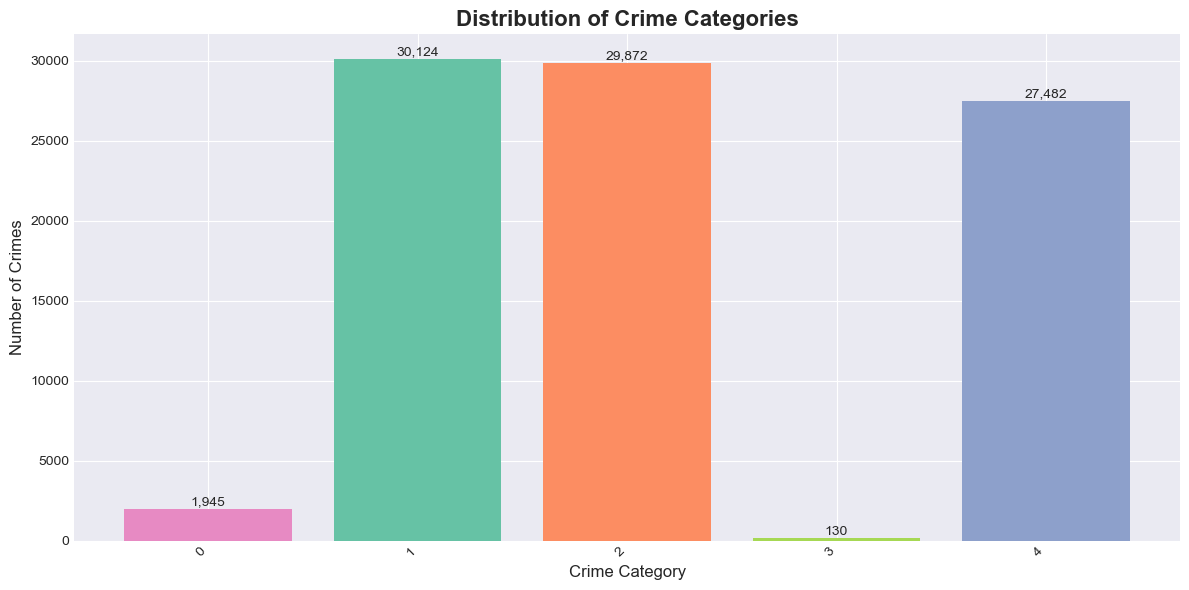

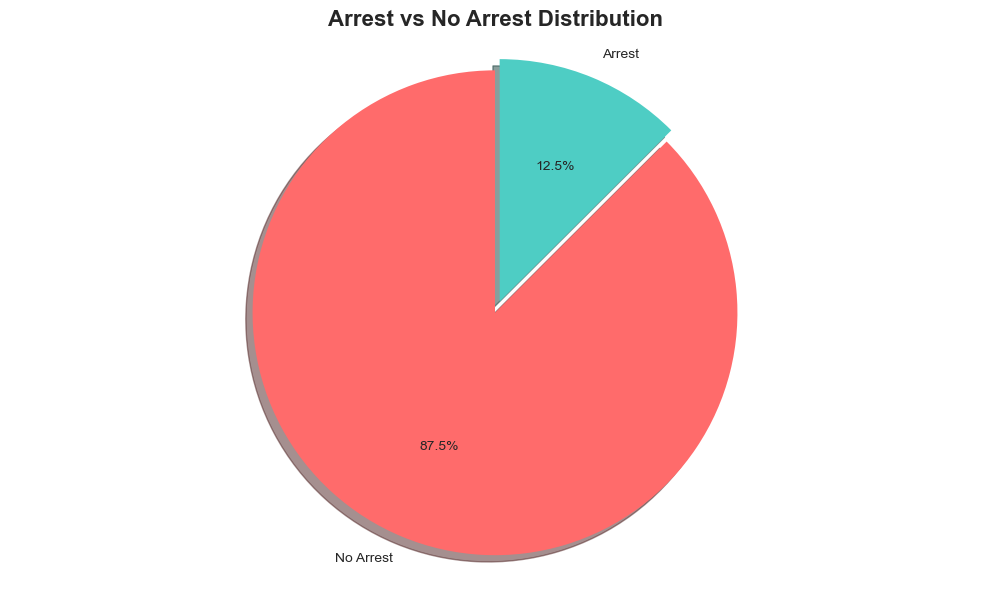

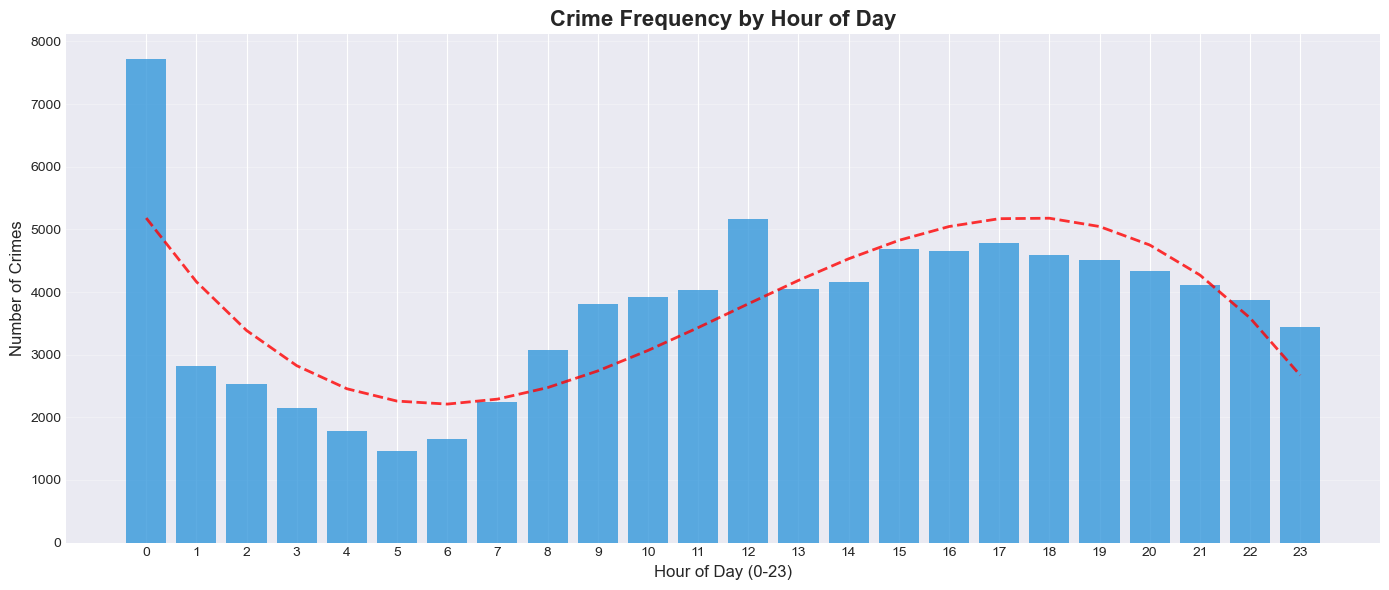

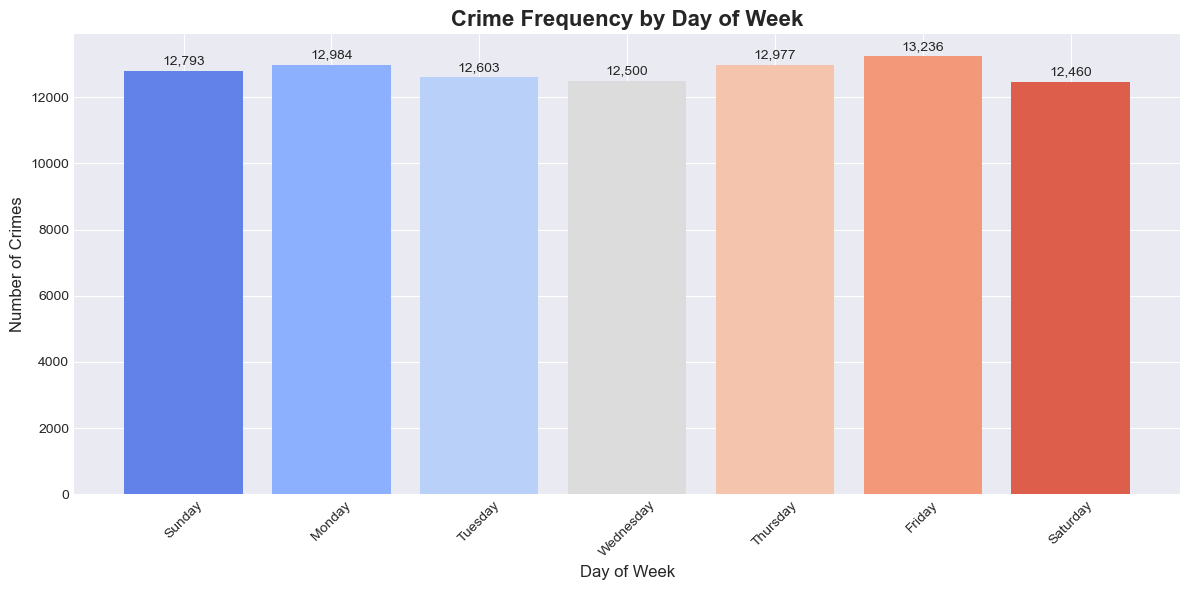

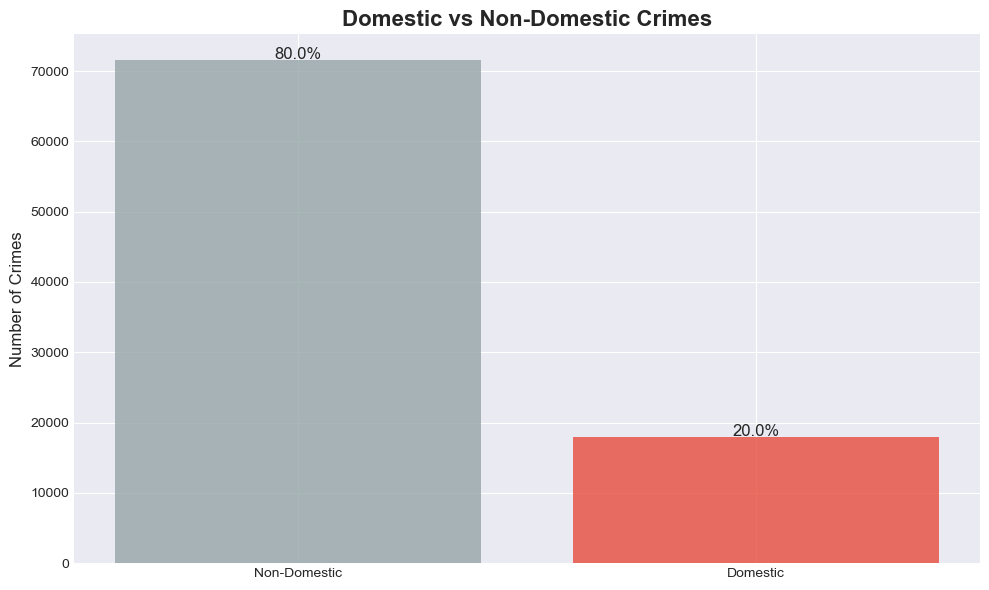

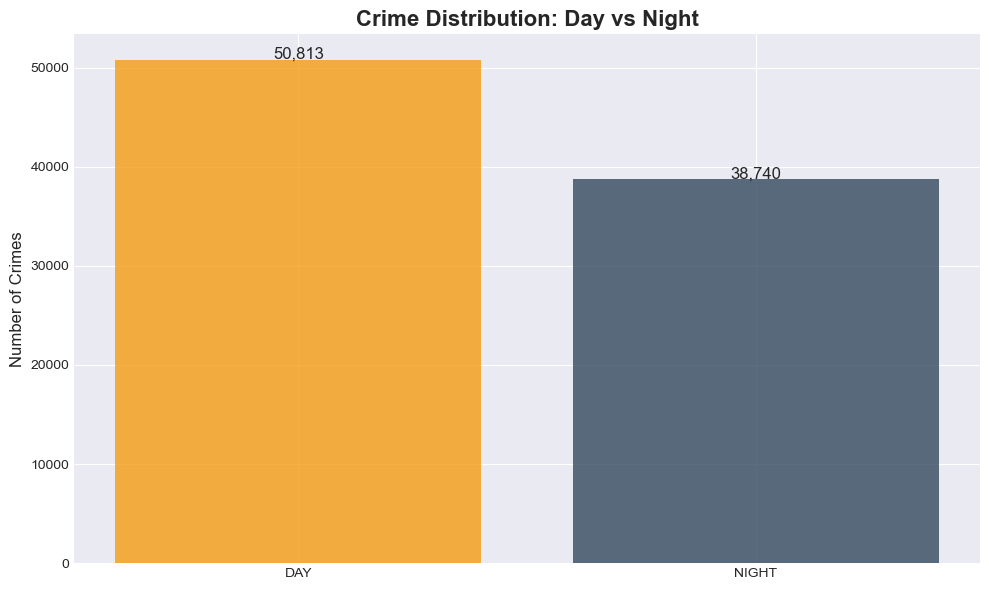

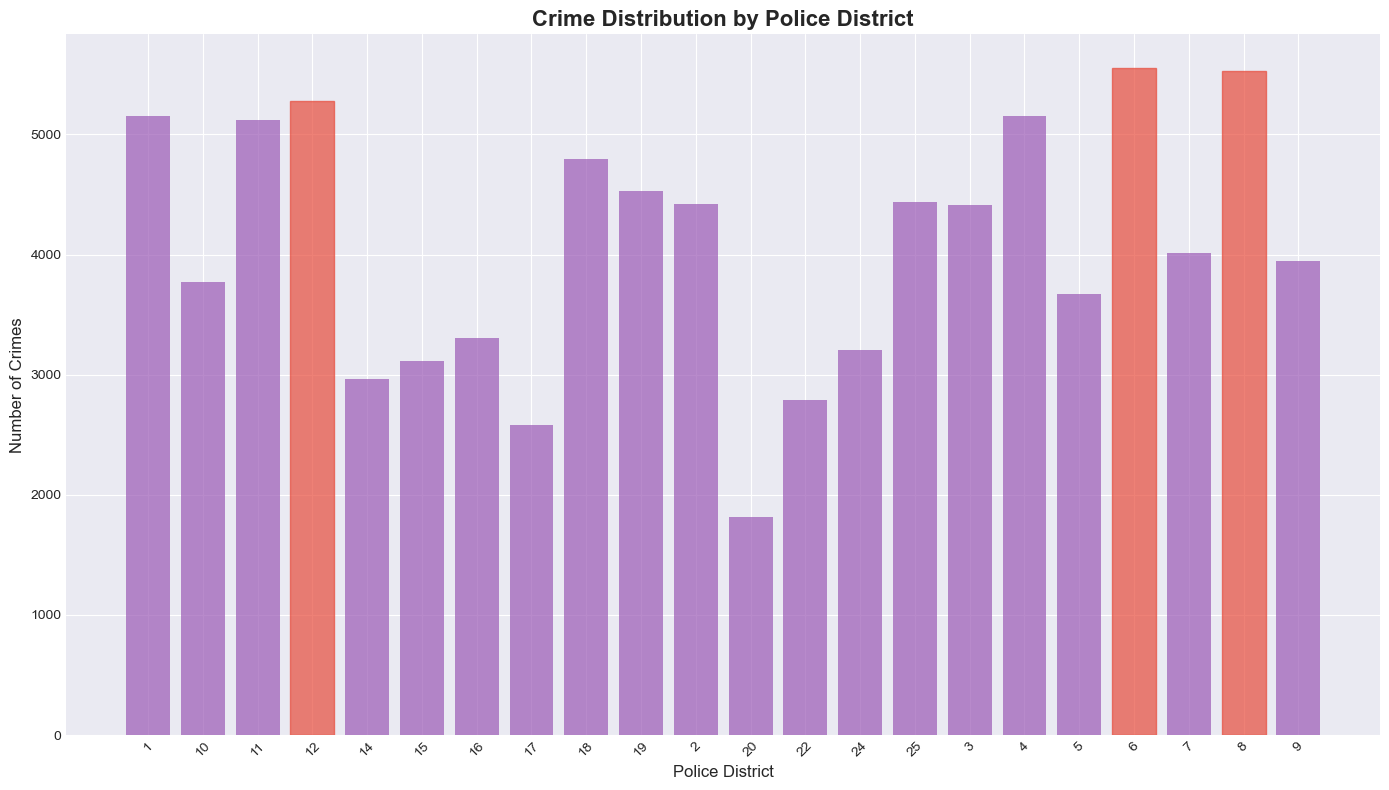

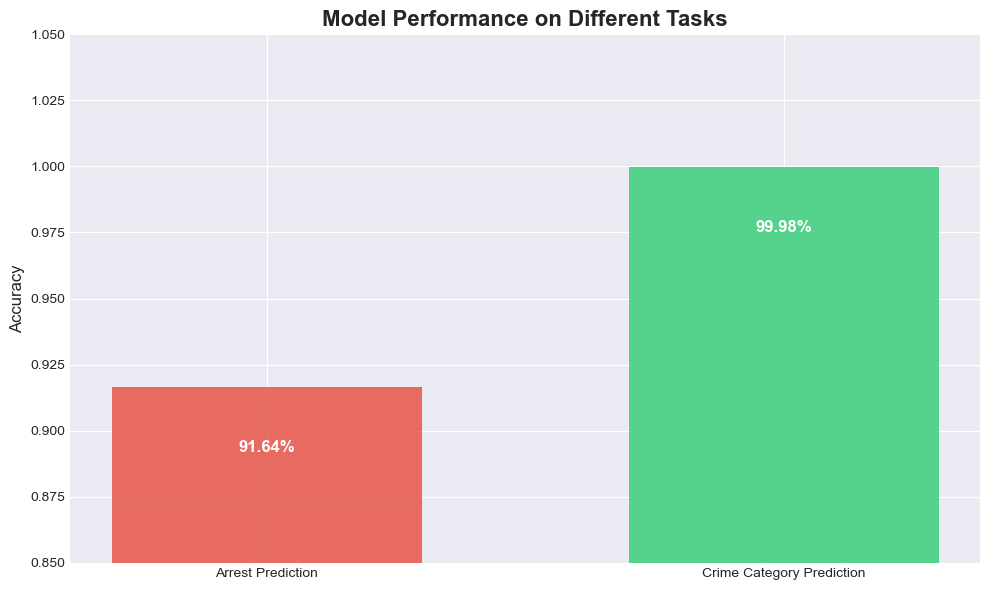

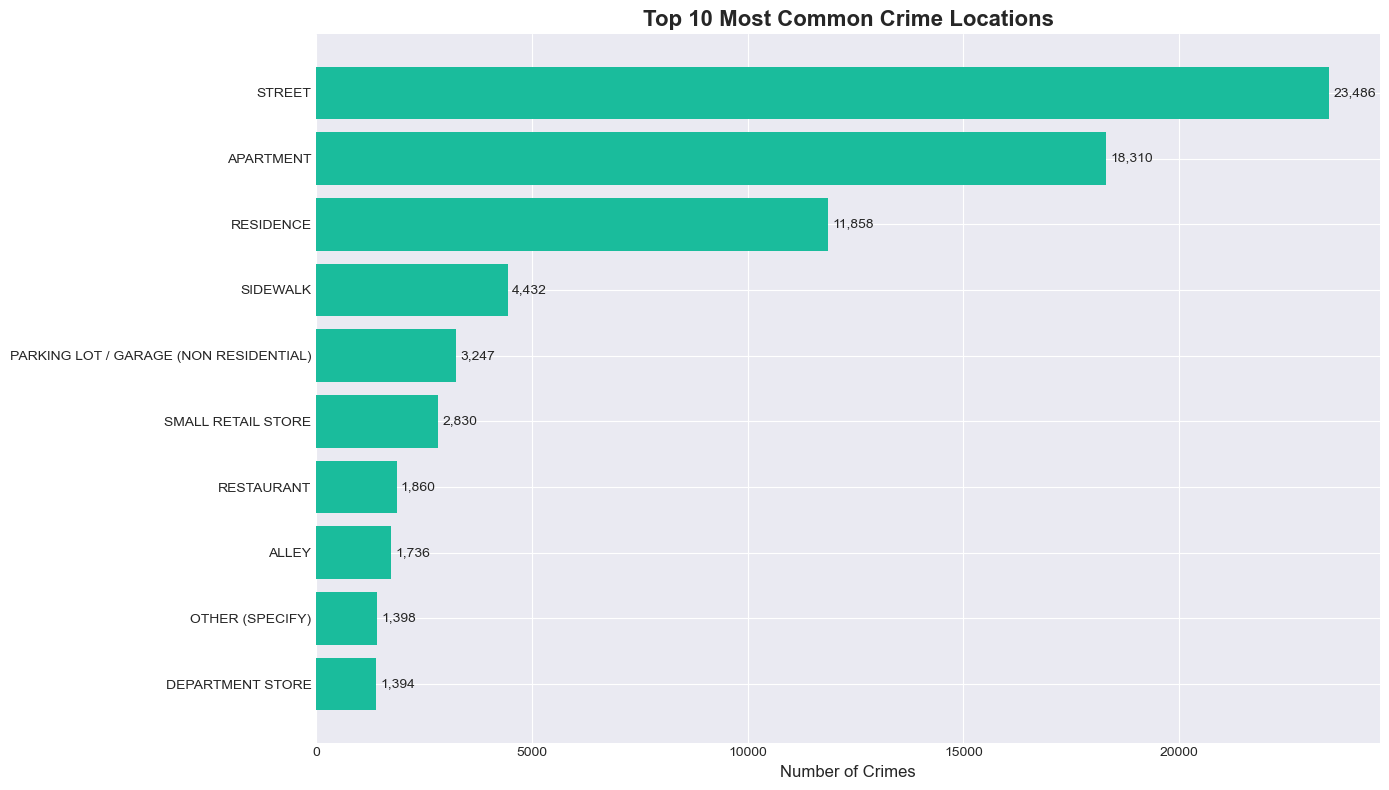

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# -------------------------------
# 1. Crime Category Distribution
# -------------------------------
plt.figure(figsize=(12, 6))
crime_counts = df['Crime Category'].value_counts()
bars = plt.bar(crime_counts.index, crime_counts.values, color=sns.color_palette("Set2"))

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

plt.title('Distribution of Crime Categories', fontsize=16, fontweight='bold')
plt.xlabel('Crime Category', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# -------------------------------
# 2. Arrest vs Non-Arrest Distribution
# -------------------------------
plt.figure(figsize=(10, 6))
arrest_counts = df['Arrest'].value_counts()
colors = ['#FF6B6B', '#4ECDC4']  # Red for No, Teal for Yes
labels = ['No Arrest', 'Arrest']

plt.pie(arrest_counts.values, labels=labels, colors=colors, autopct='%1.1f%%', 
        startangle=90, explode=(0.05, 0), shadow=True)
plt.title('Arrest vs No Arrest Distribution', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

# -------------------------------
# 3. Crime by Hour of Day
# -------------------------------
plt.figure(figsize=(14, 6))
hour_counts = df['HourofDay'].value_counts().sort_index()

plt.bar(hour_counts.index, hour_counts.values, color='#3498db', alpha=0.8)
plt.title('Crime Frequency by Hour of Day', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day (0-23)', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', alpha=0.3)

# Add a trend line
z = np.polyfit(hour_counts.index, hour_counts.values, 3)
p = np.poly1d(z)
plt.plot(hour_counts.index, p(hour_counts.index), "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()

# -------------------------------
# 4. Crime by Day of Week
# -------------------------------
plt.figure(figsize=(12, 6))
day_names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
day_counts = df['DayOfWeek'].value_counts().sort_index()

bars = plt.bar(day_names, day_counts.values, color=sns.color_palette("coolwarm", 7))

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 100,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

plt.title('Crime Frequency by Day of Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------
# 5. Domestic vs Non-Domestic Crimes
# -------------------------------
plt.figure(figsize=(10, 6))
domestic_counts = df['Domestic'].value_counts()
labels_domestic = ['Non-Domestic', 'Domestic']
colors_domestic = ['#95a5a6', '#e74c3c']

plt.bar(labels_domestic, domestic_counts.values, color=colors_domestic, alpha=0.8)
plt.title('Domestic vs Non-Domestic Crimes', fontsize=16, fontweight='bold')
plt.ylabel('Number of Crimes', fontsize=12)

# Add percentage labels
total = domestic_counts.sum()
for i, (label, count) in enumerate(zip(labels_domestic, domestic_counts.values)):
    percentage = (count / total) * 100
    plt.text(i, count + 100, f'{percentage:.1f}%', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# -------------------------------
# 6. Day vs Night Crime Distribution
# -------------------------------
plt.figure(figsize=(10, 6))
daynight_counts = df['DayorNight'].value_counts()
colors_dn = ['#f39c12', '#34495e']  # Orange for DAY, Dark blue for NIGHT

plt.bar(daynight_counts.index, daynight_counts.values, color=colors_dn, alpha=0.8)
plt.title('Crime Distribution: Day vs Night', fontsize=16, fontweight='bold')
plt.ylabel('Number of Crimes', fontsize=12)

# Add value labels
for i, (label, count) in enumerate(zip(daynight_counts.index, daynight_counts.values)):
    plt.text(i, count + 100, f'{int(count):,}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# -------------------------------
# 7. District-wise Crime Heatmap
# -------------------------------
plt.figure(figsize=(14, 8))
district_counts = df['District'].value_counts().sort_index()

plt.bar(district_counts.index.astype(str), district_counts.values, color='#9b59b6', alpha=0.7)
plt.title('Crime Distribution by Police District', fontsize=16, fontweight='bold')
plt.xlabel('Police District', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.xticks(rotation=45)

# Highlight top 3 districts
top_3 = district_counts.nlargest(3)
for district in top_3.index:
    idx = list(district_counts.index).index(district)
    plt.gca().get_children()[idx].set_color('#e74c3c')  # Red color for top 3

plt.tight_layout()
plt.show()

# -------------------------------
# 8. Model Performance Visualization
# -------------------------------
# Create a visualization for model accuracy
plt.figure(figsize=(10, 6))

# Accuracy scores from your model evaluation
tasks = ['Arrest Prediction', 'Crime Category Prediction']
accuracies = [0.9164, 0.9998]  # Replace with your actual accuracy values
colors_perf = ['#e74c3c', '#2ecc71']

bars = plt.bar(tasks, accuracies, color=colors_perf, alpha=0.8, width=0.6)
plt.title('Model Performance on Different Tasks', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([0.85, 1.05])

# Add accuracy labels on bars
for bar, accuracy in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height - 0.02,
             f'{accuracy*100:.2f}%', ha='center', va='top', 
             color='white', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# -------------------------------
# 9. Top 10 Location Descriptions for Crimes
# -------------------------------
plt.figure(figsize=(14, 8))
top_locations = df['Location Description'].value_counts().head(10)

bars = plt.barh(range(len(top_locations)), top_locations.values, color='#1abc9c')
plt.yticks(range(len(top_locations)), top_locations.index)
plt.gca().invert_yaxis()  # Highest at top
plt.title('Top 10 Most Common Crime Locations', fontsize=16, fontweight='bold')
plt.xlabel('Number of Crimes', fontsize=12)

# Add value labels
for i, (location, count) in enumerate(zip(top_locations.index, top_locations.values)):
    plt.text(count + 100, i, f'{int(count):,}', va='center', fontsize=10)

plt.tight_layout()
plt.show()


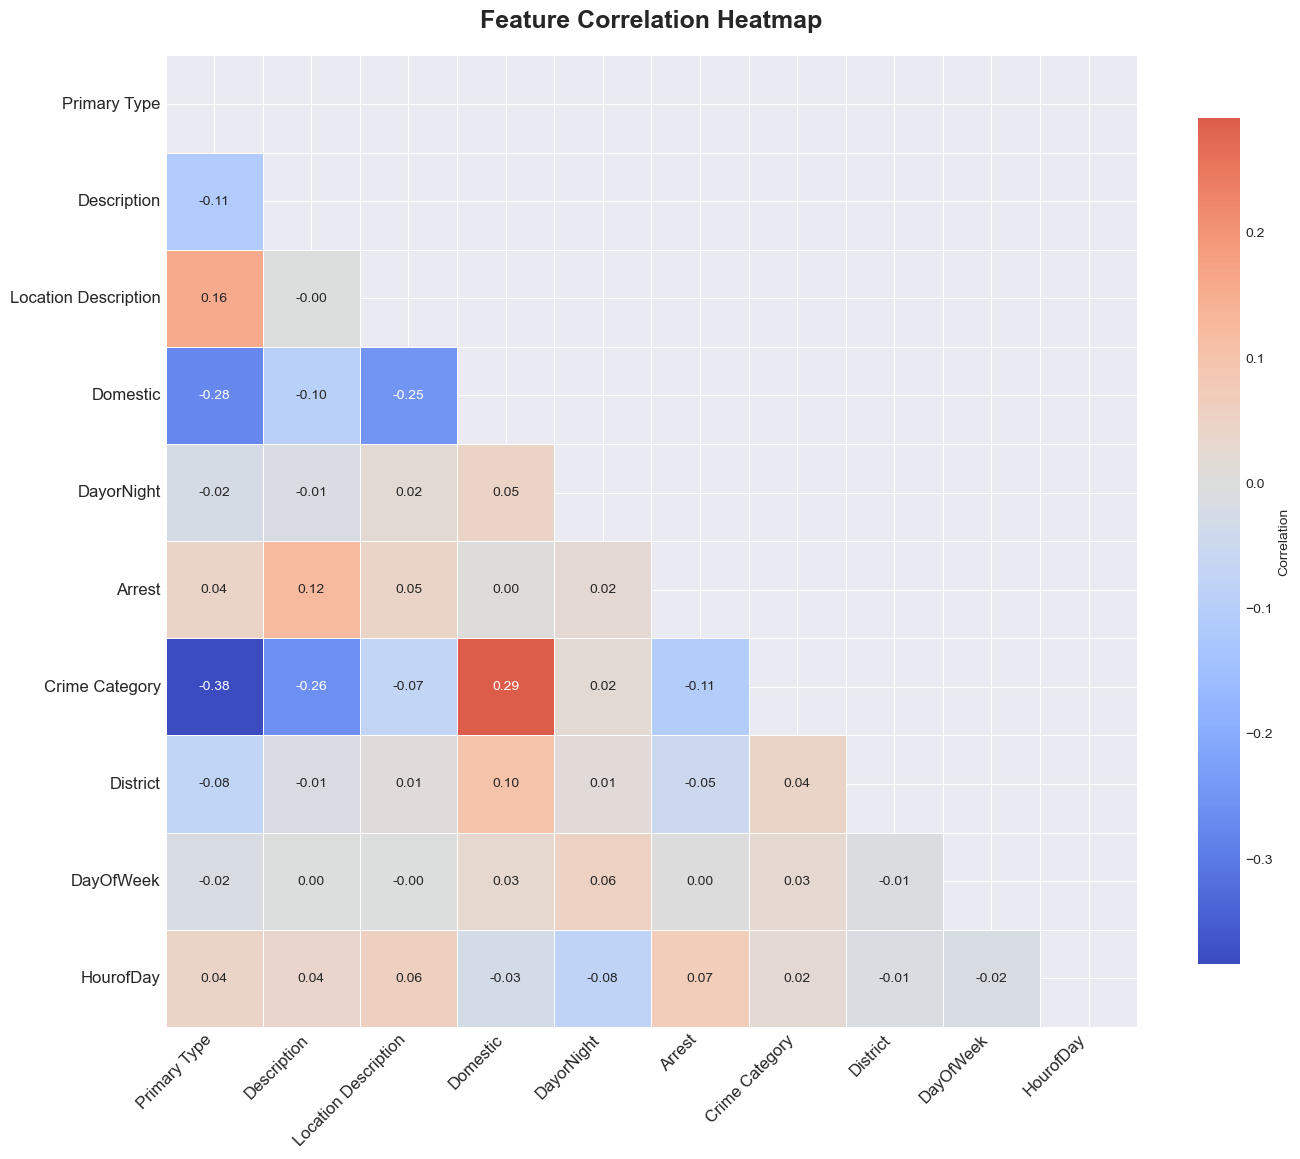

In [49]:
# ============================================
# CORRELATION HEATMAP
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['figure.dpi'] = 100

# Prepare data
temp_df = df.copy()

cols_for_corr = []
for col in ['Primary Type', 'Description', 'Location Description', 
            'Domestic', 'DayorNight', 'Arrest', 'Crime Category', 
            'District', 'DayOfWeek', 'HourofDay']:
    if col in temp_df.columns:
        cols_for_corr.append(col)

# Convert categorical to numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in cols_for_corr:
    if temp_df[col].dtype == 'object':
        temp_df[col] = le.fit_transform(temp_df[col].astype(str))
    elif temp_df[col].dtype == 'bool':
        temp_df[col] = temp_df[col].astype(int)

# Calculate correlation
corr_df = temp_df[cols_for_corr]
correlation_matrix = corr_df.corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

heatmap = sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Correlation"},
    ax=ax
)

ax.set_title('Feature Correlation Heatmap', fontsize=18, fontweight='bold', pad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)

plt.tight_layout()
plt.show()

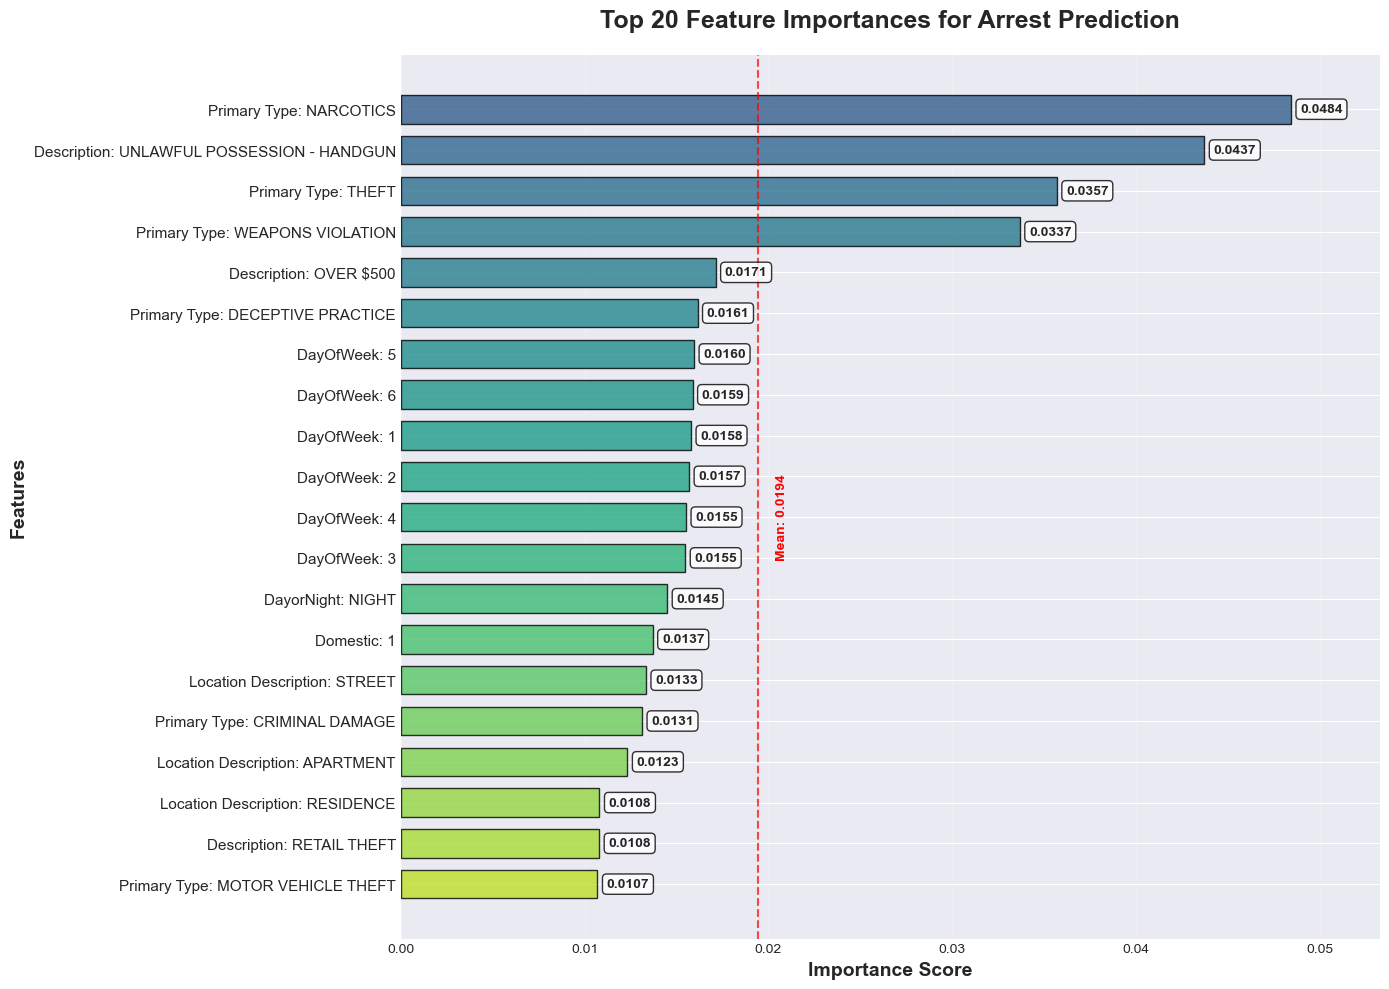

In [48]:
# ============================================
# 🎯 FEATURE IMPORTANCE VISUALIZATION
# ============================================

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn-v0_8-darkgrid')

try:
    feature_names = preprocessor.get_feature_names_out()
    rf_estimator_arrest = multi_target_rf.estimators_[0]
    importances = rf_estimator_arrest.feature_importances_
    
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(20)
    
    feature_importance_df['Feature_Clean'] = feature_importance_df['Feature'].str.replace('cat__', '')
    feature_importance_df['Feature_Clean'] = feature_importance_df['Feature_Clean'].str.replace('_', ': ')
    
    plt.figure(figsize=(14, 10))
    
    bars = plt.barh(range(len(feature_importance_df)), 
                    feature_importance_df['Importance'], 
                    color=plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_importance_df))),
                    edgecolor='black',
                    alpha=0.8,
                    height=0.7)
    
    plt.yticks(range(len(feature_importance_df)), 
               feature_importance_df['Feature_Clean'],
               fontsize=11)
    
    plt.gca().invert_yaxis()
    
    plt.title('Top 20 Feature Importances for Arrest Prediction', 
              fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Importance Score', fontsize=14, fontweight='bold')
    plt.ylabel('Features', fontsize=14, fontweight='bold')
    
    plt.grid(axis='x', alpha=0.3, linestyle='--')
    
    for i, (feature, importance) in enumerate(zip(feature_importance_df['Feature_Clean'], 
                                                   feature_importance_df['Importance'])):
        plt.text(importance + 0.0005, i, f'{importance:.4f}', 
                 va='center', fontsize=10, fontweight='bold',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    mean_importance = feature_importance_df['Importance'].mean()
    plt.axvline(x=mean_importance, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
    plt.text(mean_importance + 0.001, len(feature_importance_df)/2, 
             f'Mean: {mean_importance:.4f}', 
             rotation=90, va='center', color='red', fontweight='bold')
    
    plt.xlim([0, feature_importance_df['Importance'].max() * 1.1])
    plt.tight_layout()
    
    plt.show()
    
except Exception as e:
    print(f"Error creating plot: {e}")